In [598]:
import numpy
import math
import tensorflow as tf
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.dates as dates
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [599]:
def import_dataframe(file, columns):
    data = pandas.read_csv(filepath_or_buffer=file, sep=';', usecols=columns)
    
    return data

In [600]:
def plot_dataframe(x, y, color):
    pyplot.figure(figsize=(25,7), frameon=False, edgecolor='black')
    pyplot.title('Sunspots per Month')
    pyplot.xlabel('Year')
    pyplot.ylabel('Sunspots')
    pyplot.scatter(x=x, y=y, color=color)
    pyplot.show()

In [601]:
def dataset_from_dataframe(x, y):
    y = y.values.reshape(-1,1)
    
    return x, y

In [602]:
def scale_dataset(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    return scaler, scaler.fit_transform(dataset)

def scale_inv_dataset(scaler, dataset):
    return scaler.inverse_transform(dataset)

In [603]:
def prepare_dataset(dataset, sequence_length, prediction_steps):
    data_x, data_y = [], []
    
    for i in range(0, len(dataset) - sequence_length - prediction_steps, prediction_steps):
        data_x.append(dataset[i:i + sequence_length])
        data_y.append(dataset[i + sequence_length + prediction_steps - 1])
        
    return numpy.array(data_x), numpy.array(data_y)

In [604]:
def lstm_input_layer(sequence_length):
    inputs = tf.placeholder(tf.float32, [None, sequence_length, 1], name='inputs')
    targets = tf.placeholder(tf.float32, [None, 1], name='targets')
    batch_size = tf.shape(inputs)[0]

    return inputs, targets, batch_size

In [605]:
def lstm_cell(hidden_layer_size, hidden_layer_depth, batch_size, dropout_rate, dropout=True):
    layers = []
    
    for i in range(hidden_layer_depth):
        layer = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        layers.append(layer)
    
    cell = tf.contrib.rnn.MultiRNNCell(layers)
    
    return cell

In [606]:
def lstm_init_state(cell, batch_size):
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return init_state

In [607]:
def lstm_init_state_gaussian(init_state, stddev):
    #NOT WORKING
    init_state_gaussian = init_state + tf.random_normal(tf.shape(init_state), stddev=stddev)
    print(tf.shape(tf.random_normal(tf.shape(init_state), stddev=stddev)))
    return init_state_gaussian

In [608]:
def lstm_output_layer(outputs, hidden_layer_size, feature_size):
    x = outputs[:, -1, :]
    weights = tf.Variable(tf.truncated_normal([hidden_layer_size, feature_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([feature_size]), name='output_layer_bias')
    output = tf.matmul(x, weights) + bias

    return output

In [609]:
def lstm_loss(logits, targets, learning_rate, grad_clip_margin):
    individual_loss = tf.reduce_sum(tf.squared_difference(logits, targets))
    loss = tf.reduce_mean(individual_loss)
    
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    
    return loss, train_optimizer

In [610]:
def lstm_accuracy(logits, targets):
    return

In [611]:
def rnn_model(cell, init_state, inputs):
    outputs, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
    return outputs, states

In [612]:
def train_model(x, y, batch_size, inputs, targets, logits, loss, optimizer):
    train_scores, train_loss = [], []
    
    for i in range(0, len(x) - batch_size, batch_size):
        batch_x = x[i:i+batch_size]
        batch_y = y[i:i+batch_size]

        session_output, session_loss, _ = session.run([logits, loss, optimizer], feed_dict={inputs:batch_x, targets:batch_y})
        
        train_loss.append(session_loss)
        train_scores.append(session_output)
        
    return train_scores, train_loss

In [613]:
lstm_epochs = 4
lstm_batch_size_expected = 4
lstm_prediction_steps = 100
lstm_sequence_length = 10
lstm_feature_size = 1
lstm_hidden_layer_size = 128
lstm_hidden_layer_depth = 1
lstm_dropout_rate = 0.2
lstm_learning_rate = 0.0001
lstm_grad_clip_margin = 4

tf.reset_default_graph()

lstm_inputs, lstm_targets, lstm_batch_size = lstm_input_layer(lstm_sequence_length)
lstm_cells = lstm_cell(lstm_hidden_layer_size, lstm_hidden_layer_depth, lstm_batch_size, lstm_dropout_rate)
lstm_init_state = lstm_init_state(lstm_cells, lstm_batch_size)
#lstm_init_state = lstm_init_state_gaussian(lstm_init_state, 0.01)
lstm_outputs, lstm_states = rnn_model(lstm_cells, lstm_init_state, lstm_inputs)
lstm_logits = lstm_output_layer(lstm_outputs, lstm_hidden_layer_size, lstm_feature_size)
lstm_loss, lstm_train_optimizer = lstm_loss(lstm_logits, lstm_targets, lstm_learning_rate, lstm_grad_clip_margin)

In [614]:
session = tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

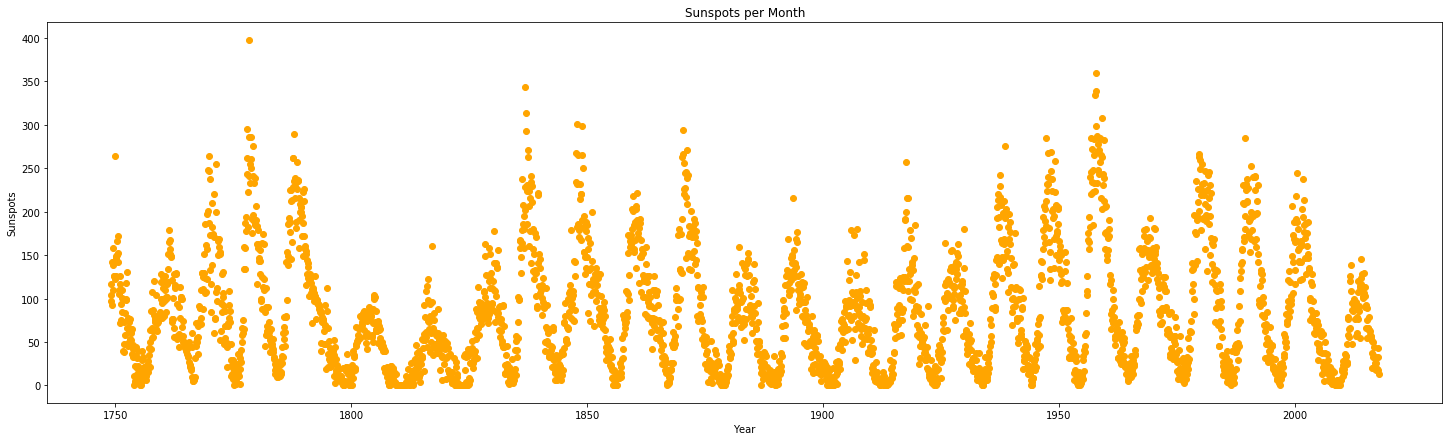

In [615]:
DATEFRACTION = 'DATEFRACTION'
DATEFRACTION_COLUMN = 2
SSN = 'SSN'
SSN_COLUMN = 3

dataframe = import_dataframe('SN_m_tot_V2.0_header.csv', [DATEFRACTION_COLUMN, SSN_COLUMN])
plot_dataframe(dataframe[DATEFRACTION], dataframe[SSN], 'orange')

dataset_x, dataset_y = dataset_from_dataframe(dataframe[DATEFRACTION], dataframe[SSN])
scaler, dataset_y = scale_dataset(dataset_y.astype('float32'))

train_size = int(len(dataset_y) * 0.6666)
test_size = len(dataset_y) - train_size

train_set = dataset_y[0:train_size]
test_set = dataset_y[train_size:]

train_x, train_y = prepare_dataset(train_set, lstm_sequence_length, lstm_prediction_steps)
test_x, test_y = prepare_dataset(test_set, lstm_sequence_length, lstm_prediction_steps)

In [616]:
total_scores, total_loss = [], []

for epoch in range(lstm_epochs):
    epoch_scores, epoch_loss = train_model(train_x, train_y, lstm_batch_size_expected, lstm_inputs, lstm_targets, lstm_logits, lstm_loss, lstm_train_optimizer)
    total_scores.append(epoch_scores)
    total_loss.append(epoch_loss)
    print("epoch:", epoch, "with loss", epoch_loss)
    #print(epoch_scores)

session.close()


epoch: 0 with loss [0.082520254, 0.10905205, 0.18120144, 0.10229994, 0.14614585]
epoch: 1 with loss [0.069462381, 0.10235472, 0.17216502, 0.078338727, 0.13955338]
epoch: 2 with loss [0.062900923, 0.10347755, 0.18521115, 0.071176246, 0.13806072]
epoch: 3 with loss [0.067274317, 0.093041018, 0.17717776, 0.076404884, 0.12883882]


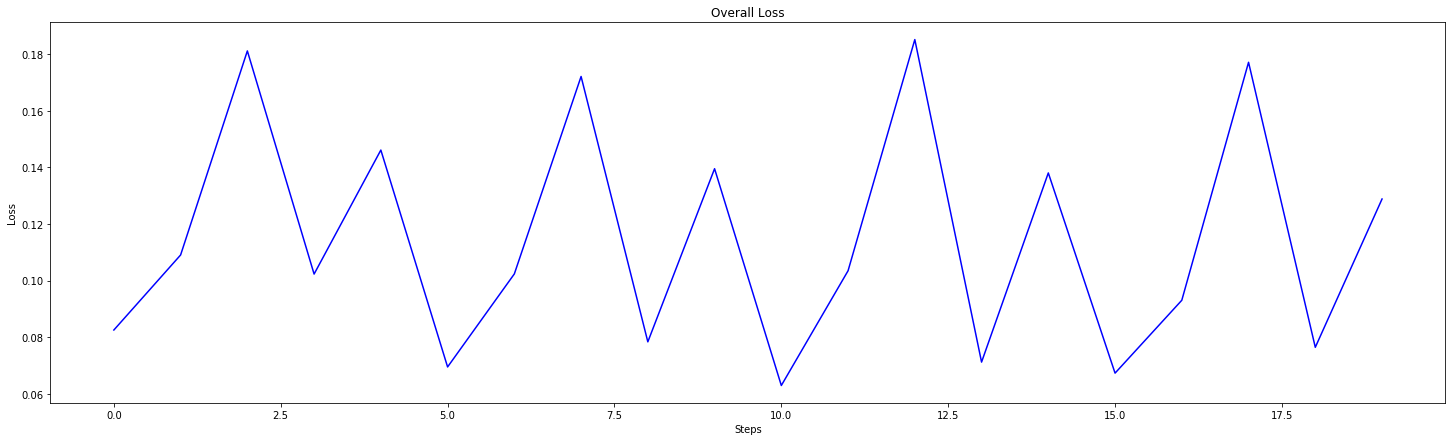

In [617]:
pyplot.figure(figsize=(25,7), frameon=False, edgecolor='black')
pyplot.title('Overall Loss')
pyplot.xlabel('Steps')
pyplot.ylabel('Loss')
pyplot.plot(numpy.array(total_loss).flatten(), color='blue')
pyplot.show()
